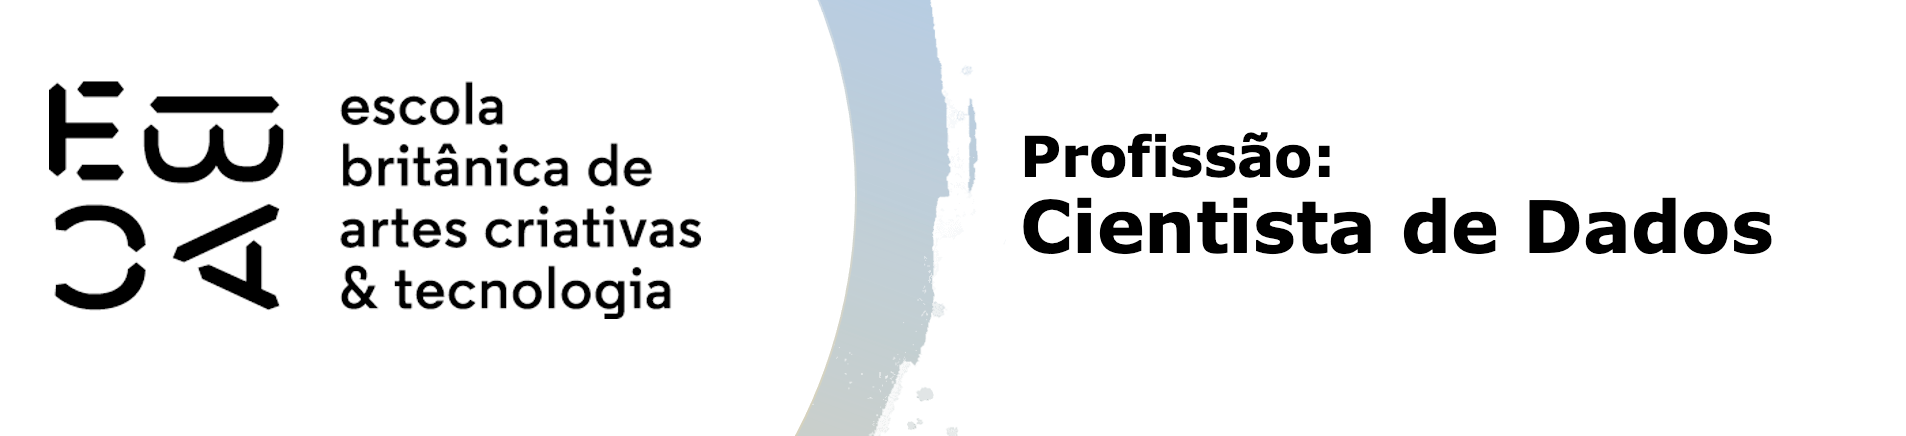

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
df.isna().sum() # verificando os faltantes

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [4]:
#Substituindo pela média
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean()) 

In [5]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [6]:
cutoff_date = df.index[-1] - pd.DateOffset(months=3) #fazemos isso para determinar a data de corte

In [7]:
#Separando em treino e teste
df_train = df[df.index < cutoff_date]
df_test = df[df.index >= cutoff_date]

In [8]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [9]:
df_train.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')

In [10]:
y_train = df_train['renda']
X_train = df_train.drop(columns=['renda', df_train.columns[0]])
X_train = pd.get_dummies(X_train, drop_first=True)
X_train = X_train.astype(int)

In [11]:
#Ajustando o modelo de regressão

model = sm.OLS(np.log(y_train), X_train).fit()
print(f'R-quadrado: {model.rsquared:.2%}')
print(model.summary())

R-quadrado: 99.03%
                                 OLS Regression Results                                
Dep. Variable:                  renda   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          2.256e+06
Date:                Sat, 20 Jul 2024   Prob (F-statistic):                        0.00
Time:                        16:38:46   Log-Likelihood:                     -7.3791e+05
No. Observations:              550000   AIC:                                  1.476e+06
Df Residuals:                  549975   BIC:                                  1.476e+06
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
---

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [12]:
predictions = model.predict(X_train)

In [13]:
# Calculando os resíduos
residuals = np.log(y_train) - predictions

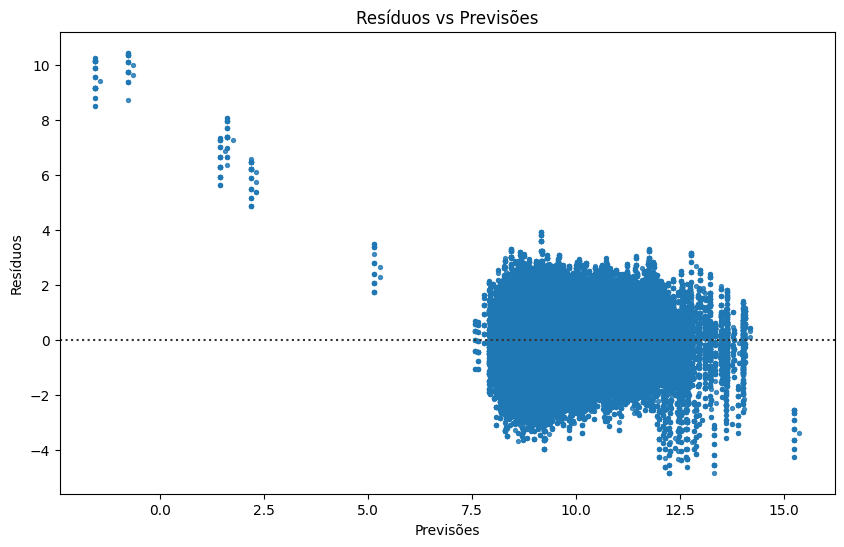

In [14]:
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, scatter_kws={'s': 8}, line_kws={'color': 'red', 'lw': 1})
plt.title('Resíduos vs Previsões')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

<Figure size 1000x600 with 0 Axes>

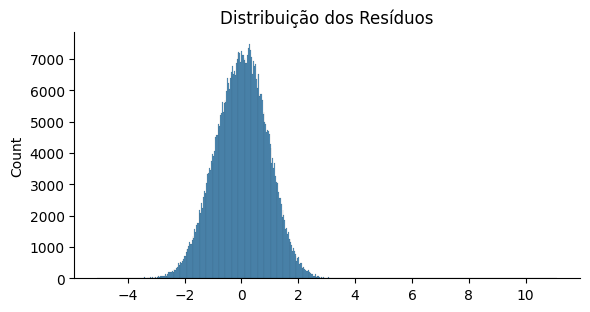

In [15]:
plt.figure(figsize=(10, 6))
sns.displot(model.resid, height=3, aspect=2);
plt.title('Distribuição dos Resíduos')
plt.show()

Os resíduos apresentam distribuição normal, com alguns outliers.

In [16]:
X_train.shape[1]

25

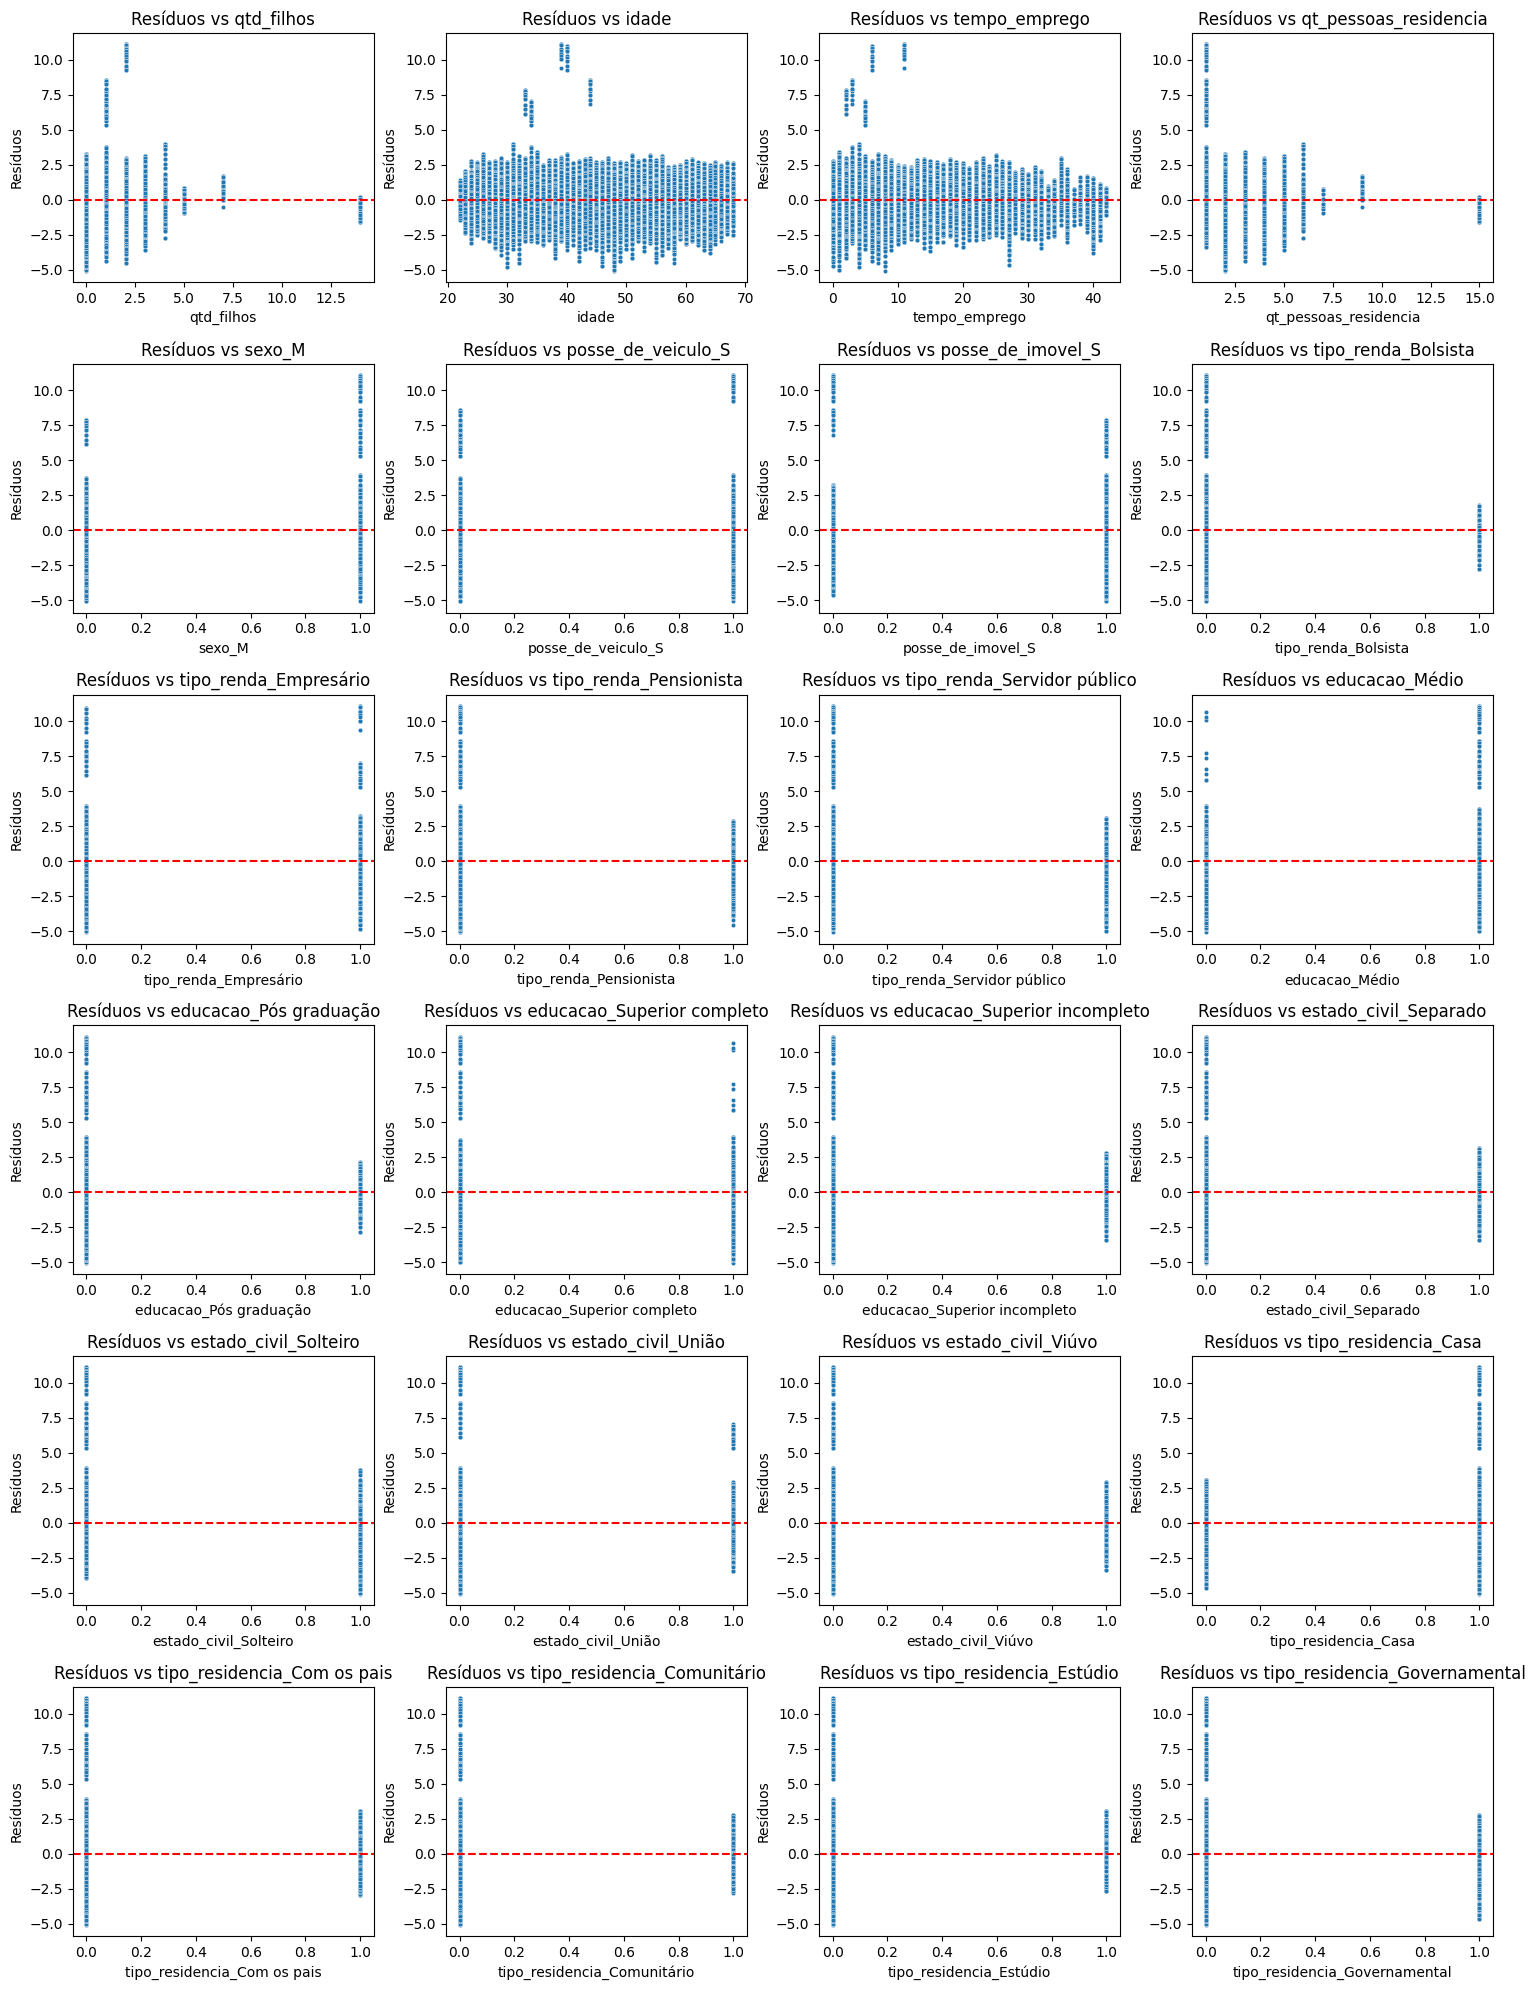

In [17]:
# Plotando os resíduos em relação a cada variável independente
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(X_train.columns[1:]):  
    ax = axes[i]
    sns.scatterplot(x=X_train[col], y=residuals, ax=ax, s=10)  
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Resíduos vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Resíduos')

plt.tight_layout()
plt.show()

Observa-se um padrão de outliers na parte superior do gráfico para quase todas as variáveis. As variáveis que não apresentam os outliers então apontam para onde o ajuste está bem feito, e onde os outliers estão concentrados. Vamos discriminar abaixo.

Na categoria Tipo de Renda, as variáveis que não apresentam outliers são:
<ul>
    <li>Tipo de Renda Bolsista (True)</li>
    <li>Tipo de Renda Pensionista (True)</li>
    <li>Tipo de Renda Servidor Publico (True)</li>
</ul>    

Isso significa que o modelo se ajusta bem a essas variáveis, e os outliers ocorrem na variável Tipo de Renda Empresário (True). Ou seja, para os empresários, é mais dificil de prever a renda, e existem muitos que possuem renda acima do previsto pelo modelo. 

Na categoria Estado Civil, as variáveis que não apresentam outliers são:
<ul>
    <li>estado civil Separado (True)</li>
    <li>estado civil Solteiro (True)</li>
    <li>estado civil Viúvo (True)</li>
</ul>    

Mostrando que o modelo se encaixa para essas variáveis, enquanto que os outliers estão concentrados para o estado civil Casado (True). 

O mesmo se aplica para outras categorias, e podemos concluir que o Tipo de Residência Casa concentra os outliers, assim como os níveis de educação Ensino Médio e Superior completo. Sendo mais difícil o modelo prever a renda para esses.


In [18]:
month = df_train['data_ref'].dt.month

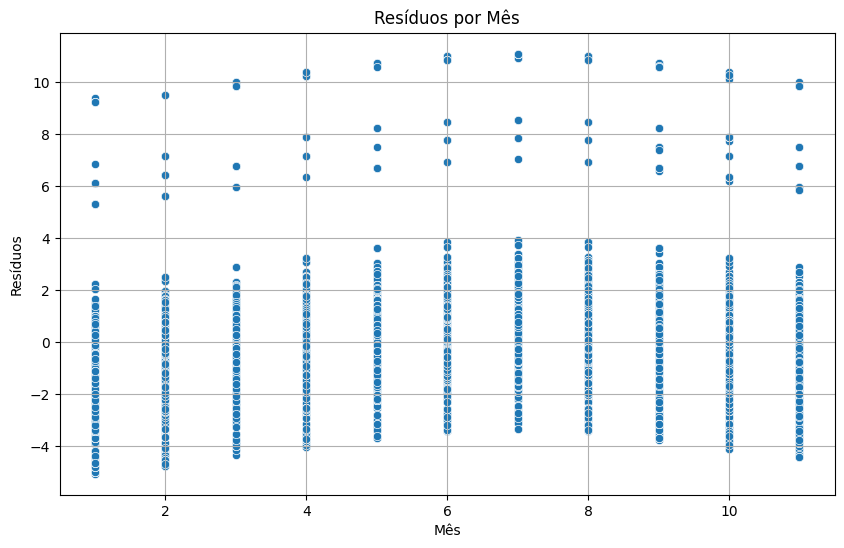

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=month, y=residuals)
plt.title('Resíduos por Mês')
plt.xlabel('Mês')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()

É possível observar uma leve variação dos resíduos com o mês de referência, parecendo ser melhor distribuidos por volta da metade do ano (centrado no 0), enquanto no início/fim do ano os resíduos tendem para o negativo. Os outliers estão consistentemente distribuidos para rendas maiores, em todos os meses. 

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

C:\Users\lucia\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


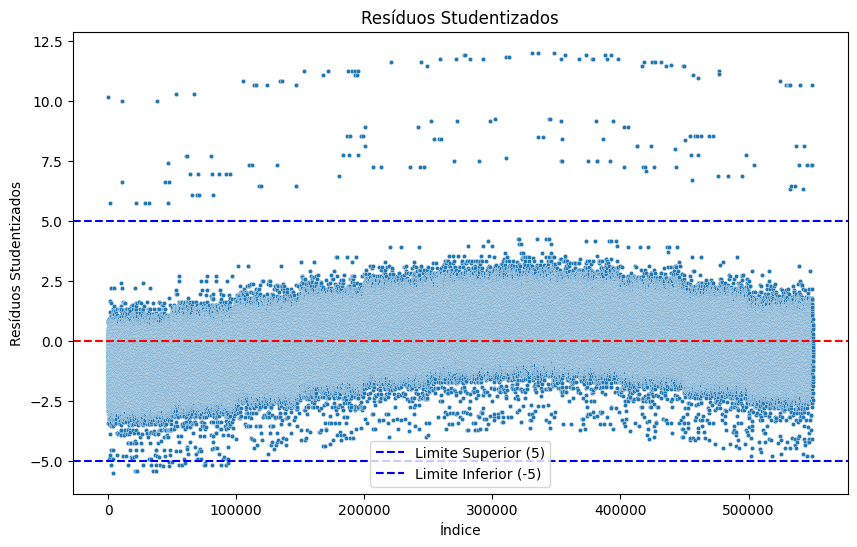

In [20]:
# Calculando os resíduos studentizados
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_internal

plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(studentized_residuals)), y=studentized_residuals, s=10)  # Ajuste o tamanho dos pontos
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=5, color='blue', linestyle='--', label='Limite Superior (5)')
plt.axhline(y=-5, color='blue', linestyle='--', label='Limite Inferior (-5)')
plt.title('Resíduos Studentizados')
plt.xlabel('Índice')
plt.ylabel('Resíduos Studentizados')
plt.legend()
plt.show()

# Identificando os outliers
outliers = np.where(np.abs(studentized_residuals) > 5)

Devido ao volume de dados, achei melhor aumentar o threshold de 3 para 5. Também devido ao volume o tempo de execução do lowess ficou muito alto para ser executado.

Esse dataset possui mais de 500 mil dados. Vamos calcular o número de outliers definido pelo threshold de 5:

In [21]:
#Porcentagem de outliers:
outlier_percent = (len(outliers[0]))/(len(residuals))
print(f'Porcentagem de outliers: {outlier_percent:.3%}')

Porcentagem de outliers: 0.036%


A proporção de outliers comparado com o volume de dados é muito pequena. A possibilidade de haver pontos influentes é pequena. 

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

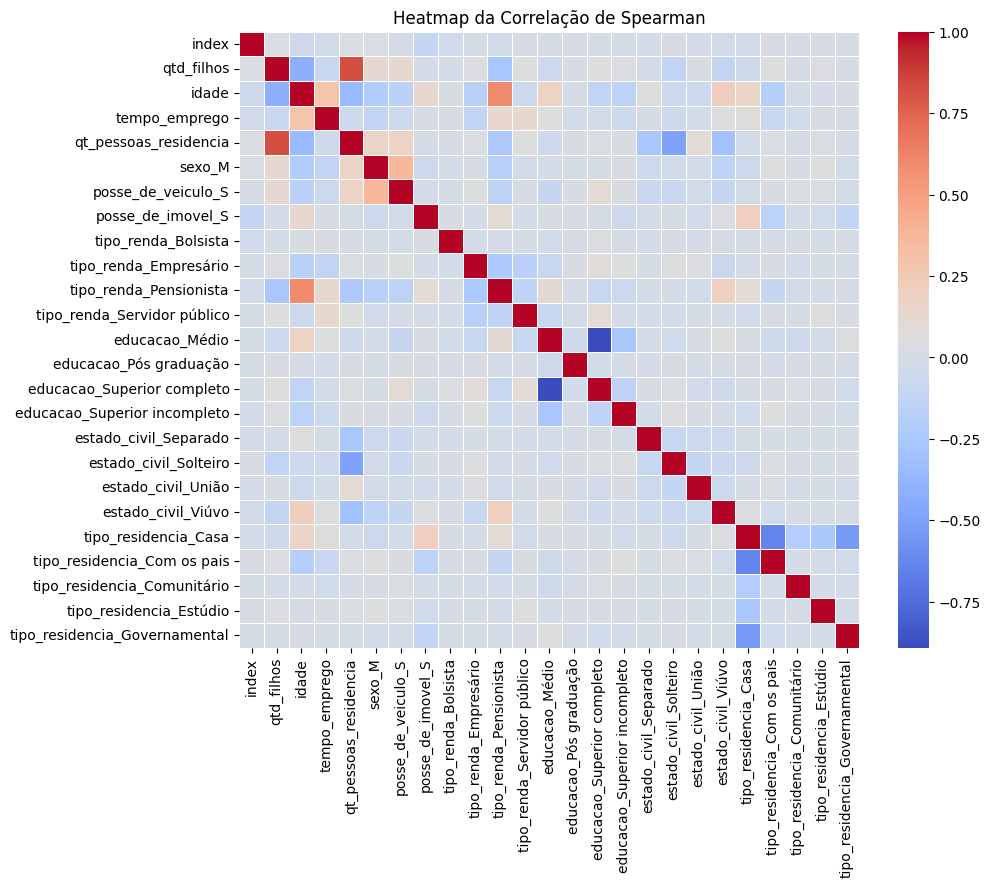

In [22]:
# Supondo que df seja o seu DataFrame com variáveis independentes
correlation_spearman = X_train.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_spearman, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap da Correlação de Spearman')
plt.show()

In [23]:
vif_results = []

# Itera sobre cada variável em X_train
for i in range(X_train.shape[1]):
    variable = X_train.columns[i]
    X_other = X_train.drop(columns=[variable])
    model_vif = sm.OLS(X_train[variable], X_other).fit()
    r2 = model_vif.rsquared
    vif = 1 / (1 - r2)
    vif_results.append({"Variable": variable, "R²": r2, "VIF": vif})

# Cria um DataFrame com os resultados
vif_data = pd.DataFrame(vif_results)
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                         Variable            R²         VIF
4           qt_pessoas_residencia      0.995918  244.960283
20           tipo_residencia_Casa      0.984434   64.242900
12                 educacao_Médio      0.981318   53.527382
1                      qtd_filhos      0.971370   34.928686
2                           idade      0.971162   34.676708
14     educacao_Superior completo      0.963852   27.664132
17          estado_civil_Solteiro      0.830633    5.904351
15   educacao_Superior incompleto      0.768337    4.316611
21    tipo_residencia_Com os pais      0.756212    4.101924
16          estado_civil_Separado      0.715174    3.510913
7               posse_de_imovel_S      0.694671    3.275154
24  tipo_residencia_Governamental      0.689857    3.224319
19             estado_civil_Viúvo      0.666316    2.996849
3                   tempo_emprego      0.638641    2.767330
10         tipo_renda_Pensionista      0.547054    2.207769
6              posse_de_veiculo_S      0

A quantidade de pessoas na residência possui uma grande correlação com a quantidade de filhos, o que faz sentido sendo que geralmente os filhos moram na mesma casa. 

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

Vamos remover a variável "qt_pessoas_residencia" que é uma informação redundante no modelo, e a variável "tipo_residencia_Casa" que também possui um VIF alto, além disso vamos remover os outliers com resíduo maior que 5. 

In [24]:
# Identificando os índices dos outliers
outliers_indices = np.where(np.abs(studentized_residuals) > 5)[0]

# Removendo os outliers dos DataFrames pelo índice
X_train_cleaned = X_train.drop(index=outliers_indices)
y_train_cleaned = y_train.drop(index=outliers_indices)

In [25]:
# Removendo variáveis do DataFrame X_train
X_train_cleaned = X_train_cleaned.drop(columns=['qt_pessoas_residencia', 'tipo_residencia_Casa'])

In [26]:
X_train_cleaned.reset_index(drop=True, inplace=True)
y_train_cleaned.reset_index(drop=True, inplace=True)

In [27]:
print("Número de amostras antes da remoção:", X_train.shape[0])
print("Número de amostras após a remoção:", X_train_cleaned.shape[0])

Número de amostras antes da remoção: 550000
Número de amostras após a remoção: 549802


In [28]:
model_cleaned = sm.OLS(np.log(y_train_cleaned), X_train_cleaned).fit()
print(model_cleaned.summary())

                                 OLS Regression Results                                
Dep. Variable:                  renda   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          1.588e+06
Date:                Sat, 20 Jul 2024   Prob (F-statistic):                        0.00
Time:                        16:43:28   Log-Likelihood:                     -8.5545e+05
No. Observations:              549802   AIC:                                  1.711e+06
Df Residuals:                  549779   BIC:                                  1.711e+06
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

O modelo corrigido apresentou um R² um pouco menor, o que indica que diminuimos um pouco o overfitting. 

In [29]:
#Preparando a base de testes
y_test = df_test['renda']
X_test = df_test.drop(columns=['renda', df_test.columns[0]])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.astype(int)

In [30]:
#Calculando o R² na base de testes no modelo original
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² no modelo original: {r2:.2f}")

R² no modelo original: -0.10


In [31]:
#Calculando o R² na base de testes no modelo corrigido

X_test_cleaned = X_test.drop(columns=['qt_pessoas_residencia', 'tipo_residencia_Casa'])

y_pred2 = model_cleaned.predict(X_test_cleaned)
r22 = r2_score(y_test, y_pred2)
print(f"R² no modelo corrigido: {r22:.2f}")

R² no modelo corrigido: -0.10


O modelo ainda parece apresentar bastante overfitting, pois o R² do ajuste na base de treino está muito alto, e o R² na base de testes está muito baixo. Talvez esse não seja o melhor tipo de ajuste para os dados. 